# **Generating Anime Characters with Deep Convolutional GANs (DCGANs) and Keras**
---

## **Usage**:

### **Character Generation**:
1. **Personalized Avatars**: Generate unique anime avatars reflecting player preferences.
2. **NPC Generation**: Create diverse NPCs for richer anime game worlds.
3. **Concept Character Creation**: Rapidly generate character designs for anime inspiration.

### **Anime Generation**
1. **Crowds and Background Characters**: Fill scenes with unique background characters to enhance immersion.
2. **Character Creation Tools**: Suggest unique anime characters based on specified traits.
3. **Dynamic Character Prototypes**: Allow artists to tweak and adjust generated characters.

### **Social Platforms**:
1. **Virtual Avatars for Social Platforms**: Personalize avatars in anime-themed social networks and platforms.
2. **AI-Generated Virtual Influencers**: Create distinct anime influencers for social media engagement.

### **Art Generation**
1. **Fan Art Generation**: Generate new characters based on favorite anime series.
2. **Interactive Visual Novel Characters**: Create dynamic characters responding to player decisions.
---

## **GANs are the Solution**

### **Generative Adversarial Networks (GANs)**
- Generative Adversarial Networks (GANs) are a type of machine learning framework introduced in June 2014 <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>.

- These networks are capable of generating **new data that mimics the statistical features of the training dataset**. GANs have gained popularity for creating new, realistic photographs that appear authentic to human observers.

### **Convolutional Neural Networks (CNNs)**
- Convolutional Neural Networks (CNNs) have become widely used in computer vision applications. By **integrating CNNs with GANs**, we can develop models that generate high-quality images.
- This combined approach is known as Deep Convolutional Generative Adversarial Networks **(DCGANs)**.
---


# **Installing  Necessary Libraries**
- Quietly Installing Packages- (Remove `> /dev/null 2>&1` For Debugging)

In [53]:
!pip install pandas==2.2.2 numpy==1.26.4 seaborn==0.13.1 matplotlib==3.7.1 scikit-learn==1.5.2 > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1
!pip3 install --upgrade tensorflow > /dev/null 2>&1

In [54]:
import os
import time
import warnings
import numpy as np
import imghdr

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU

from IPython import display
from pathlib import Path
from tqdm import tqdm




In [55]:
warnings.simplefilter('ignore')
print(f"tensorflow version: {tf.__version__}")
%matplotlib inline

tensorflow version: 2.17.0


In [56]:
def plot_dist(real_data, generated_data, discriminator=None, density=True, RealDataName="Real Data", GenerateDataName="generated data q(z)"):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='green', alpha=0.75, label=RealDataName)
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='red', alpha=0.75,label=GenerateDataName)

    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()



def plot_arr(X,title=""):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

---
## **Applications**
* Generate Photographs of Human Faces
* Generate Realistic Photographs
* Generate Cartoon Characters
* Image-to-Image Translation
* Text-to-Image Translation
* Face Frontal View Generation
* Generate New Human Poses
* Face Aging
* Photo Blending
* Super Resolution
* Photo Inpainting
* Clothing Translation
* Video Prediction

# Imagine a Game of **Cakes** Between a Baker and a Food Critic

Let’s use the idea of making **cakes**! In our world, we have two characters:

- **The Baker (Generator – G):** The one who makes cakes but starts off without knowing much about baking.
- **The Food Critic (Discriminator – D):** The expert who has tasted lots of real cakes and can judge if a cake is delicious and real or just a fake, bad cake.

## **The Goal**
The goal is for the **Baker (G)** to make a cake that is **so good** that the **Food Critic (D)** can’t tell whether it was made by a beginner or a master baker!

---

## **How the Game Works**

### Step 1: The Baker Makes the First Cake
At the beginning of the game, the **Baker** doesn't know how to bake a good cake at all. They take a bunch of random ingredients and throw them together into a messy, weird-looking cake.

- **Baker’s cake = Fake cake** (It looks bad and probably tastes bad).
- **Food Critic** looks at the cake, takes one bite, and says, "This is a terrible cake! Definitely fake!" and easily recognizes it as not a real, delicious cake.

---

### Step 2: The Food Critic Helps the Baker Improve
The **Food Critic (D)** is like a teacher in a way. When they say the cake is bad, the **Baker (G)** gets feedback and learns from it. The **Baker** now knows what was wrong with the cake (too salty, too weird-looking) and tries to make a better one next time.

- The **Baker** mixes the ingredients differently and bakes another cake.
- The **Food Critic** checks again. The new cake might still be bad, but maybe it's **slightly better** than the first one. The **Food Critic** still says, "Nope, this is not a real cake!"

---

### Step 3: The Game Repeats, Over and Over
Each time the **Baker (G)** makes a cake, they try to make it **look and taste more like a real, yummy cake**. They want to trick the **Food Critic** into thinking it's a good cake.

But the **Food Critic (D)** is also **getting better** at their job! They have eaten hundreds of cakes before, so they learn how to **spot even small mistakes** and tell which cakes are real and which are fake.

---

### Step 4: Baker Starts to Get Really Good
After many rounds of trying and learning from the **Food Critic’s** feedback, the **Baker** starts to get the hang of it. Maybe now the cake looks fluffy, has the right colors, and smells delicious! The **Food Critic** starts getting confused.

- Sometimes, the **Food Critic** might look at a cake and **almost** think it’s real but still finds a tiny problem and says, "Wait, this frosting doesn't look perfect. Fake!"

---

### Step 5: Finally, the Baker Wins!
After many attempts, the **Baker** finally makes a cake that is so good, the **Food Critic** can’t tell if it’s fake anymore! The cake **looks, smells, and tastes just like a real cake**.

- The **Food Critic** is **fooled**!
- The **Baker** wins because they have learned to make a cake that looks just as real as a cake from a professional bakery!

---

## **How This Relates to a GAN**:
In a **GAN (Generative Adversarial Network)**, the two parts are always **competing** with each other and learning at the same time:

1. **Baker = Generator (G):** The generator starts with random noise (like a bunch of random ingredients) and learns how to create something that looks like the real data (real cakes).
   
2. **Food Critic = Discriminator (D):** The discriminator tries to tell if what it’s looking at is real or fake (real cakes vs. fake cakes). At first, it can easily spot fake ones, but as the **Generator** gets better, it becomes harder for the **Discriminator** to tell.

- The **Baker (Generator)** gets better at making realistic things.
- The **Food Critic (Discriminator)** gets better at spotting fakes.
  
They both improve by **competing** with each other, and in the end, the **Generator** becomes so good at creating realistic-looking cakes (or images, in the case of a GAN), that even an expert can’t tell they’re fake.

---

## **Let’s Go Deeper into the GAN Process**

Now that you understand the basic idea of the game, let’s break down how a GAN works step by step:

1. **The Generator (G):**
   - Think of this as the **Baker** who starts with random noise (like a bunch of random ingredients) and tries to create something meaningful, like an image or a cake. The Generator creates **fake examples**.
   
2. **The Discriminator (D):**
   - This is like the **Food Critic** who looks at two things:
     - **Real Data** (real cakes or real images)
     - **Fake Data** created by the **Generator**.
   - The **Discriminator** tries to tell which one is real and which one is fake. The better it gets, the harder it becomes for the Generator to fool it.

3. **The Feedback Loop:**
   - Every time the **Discriminator** spots a fake, the **Generator** learns from it and tries again.
   - The **Generator** improves bit by bit, making its creations more realistic.
   - The **Discriminator** also improves and gets better at identifying the fakes.

4. **Training Process:**
   - This process of the **Generator** creating fake data and the **Discriminator** judging it happens **thousands** of times.
   - Over time, the **Generator** creates fake images or data that are so convincing, they **look just like the real thing**.

---

## **Summary in Fun Terms**:
- **Baker (Generator):** Learns to make realistic cakes (images).
- **Food Critic (Discriminator):** Tries to tell if the cakes are real or fake.
- **Feedback Loop:** Each time the Baker makes a better cake, and the Critic gets better at judging it.
- **End Result:** The Baker becomes so good that even the Food Critic is fooled into thinking the fake cakes are real!

---

GANs are like a **friendly competition** between two players who keep learning from each other until one of them (the Generator) becomes **amazingly skilled** at creating things that look like real-world objects!

---

## **Toy Data**

#### **Sampling Data from a Normal Distribution**

- We have some data, which we'll call **x**, and we know that it follows a normal distribution. This distribution is described by two important properties:

- **Mean**: The center of the distribution, which is 10.
Standard Deviation: The spread of the data around the mean, which is 1.

- So, the data x is normally distributed with:
- **Mean** = 10
- **Standard deviation** = 1
- `x ~ N(10, 1)`

In [57]:
mean = [10]
cov = [[1]]

Z = tf.random.normal((5000,1), mean=0, stddev=2)
X = tf.random.normal((5000,1), mean=10, stddev=1)

'''
  1. mean = [10]
  - This defines the mean of the data distribution.
  - It's set to 10, meaning the center of our data will be around 10.

  2. cov = [[1]]
  - This is meant to define the covariance or variance of the data, but in this case,
  - it's not used because you're generating data directly using TensorFlow's tf.random.normal function.
  - Covariance indicates how much variables change together, and since we only have one variable here (1-dimensional data),
  - it's just a single value (1), which is the variance.

  3. X = tf.random.normal((5000,1), mean=10, stddev=1.0)
  - This function from TensorFlow generates 5000 random samples from a normal distribution.
  - Each sample is one-dimensional (shape: 5000x1).
  - So, this line creates a sample of 5000 points drawn from a normal distribution with a mean of 10 and a standard deviation of 1.

  4. print("mean:", np.mean(X))
  - This prints the mean of the generated data X.
  - Since we drew samples from a distribution with a mean of 10,
  - We expect the printed value to be very close to 10 (it might not be exactly 10 due to random sampling).

  5. print("standard deviation:", np.std(X))
  - This prints the standard deviation of the generated data X.
  - Since the data was generated with a standard deviation of 1,
  - we expect the printed value to be close to 1.
'''


print("Mean:", np.mean(X))
print("Mean:", np.mean(Z))
print("Standard Deviation:", np.std(X))
print("Standard Deviation:", np.std(Z))

Mean: 10.006339
Mean: -0.011753998
Standard Deviation: 0.9999882
Standard Deviation: 1.9620637


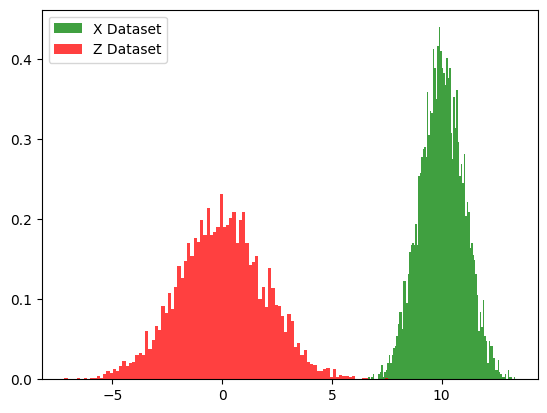

In [58]:
plot_dist(X,Z,discriminator=None,density=True, RealDataName='X Dataset', GenerateDataName='Z Dataset')

In [59]:
Xhat= (Z + 10)

- We made a new set of data by adding 10 to each value in the original data.
- This new data is similar to the original and is spread out in a way that can be described as a **bell-shaped curve**,
- with an average value of 10 and a certain amount of variation.

Mean: 9.988246
Standard Deviation: 1.9620638


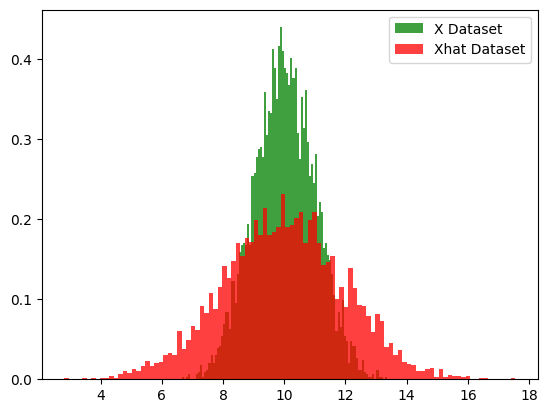

In [60]:
print("Mean:", np.mean(Xhat))
print("Standard Deviation:", np.std(Xhat))

plot_dist(X, Xhat, discriminator=None, density=True, RealDataName='X Dataset', GenerateDataName='Xhat Dataset')

## **The Generator**:

- In a **Generative Adversarial Network (GAN)****, there are two main components: the Generator and the Discriminator.

- The **Generator** is a type of neural network (**NNs**), and it is designed to learn and mimic any kind of data distribution. This capability is based on a principle that suggests neural networks can approximate any function.

- Our main objective for the Generator is to **take random input samples and transform them into data that resembles real samples**. In this case, we want the output to be similar to the data we want to generate.

- To create a simple Generator, we can use a structure where the output is based on the input samples, combined with **some learned weights and biases**. We will use Keras, a popular machine learning library, to build this Generator model.

- The following function will create a **Generator using Keras's Sequential model**, which allows us to stack layers to build our neural network.


In [61]:
def MakeGeneratorModel():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

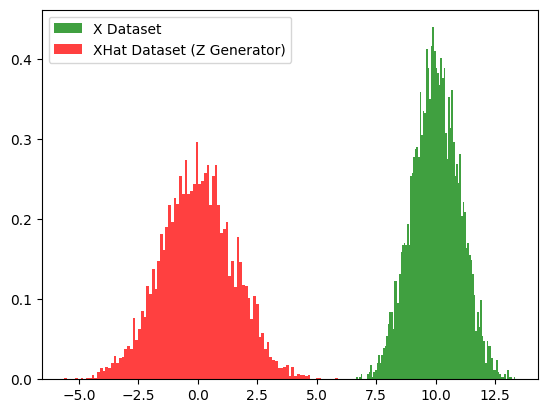

In [62]:
generator = MakeGeneratorModel()

Xhat = generator(Z, training=False)
plot_dist(real_data=X, generated_data=Xhat, RealDataName='X Dataset', GenerateDataName='XHat Dataset (Z Generator)')

## **The Discriminator**

- The discriminator D(x) is a neural network that learns to distinguish between actual and generated samples.

- The simplest Discriminator is a simple logistic regression function.

- Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function,

- which is the convention in Keras.

In [63]:
def MakeDiscriminatorModel():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=MakeDiscriminatorModel()

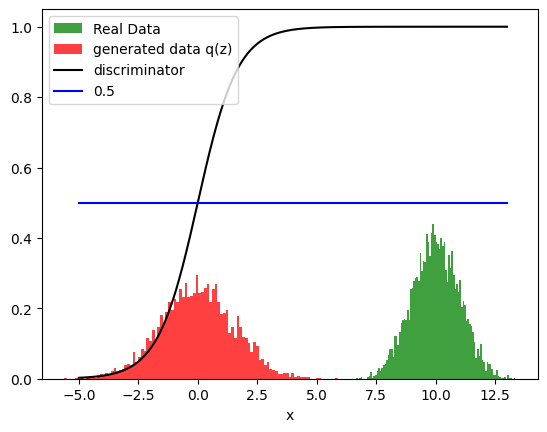

In [64]:
plot_dist(real_data = X, generated_data = Xhat, discriminator=discriminator)

- The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis.

- We also include the threshold.
- **If the output of the logistic function is less than 0.5, the sample is classified as generated data**;
- conversely, **if the output is greater than 0.5, the sample will be classified as data that came from the real distribution**.

#### **Sigmoid**
- Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

- For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:

In [66]:
py_x = tf.math.sigmoid(discriminator(X,training = False))
np.sum(py_x > 0.5)

5000

#### **Interpretation**
- For the generated data, only a part of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.